In [24]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns
import math
from sklearn.metrics import average_precision_score, precision_recall_curve

from ete3 import NCBITaxa
from Bio import SeqIO
import taxoniq
import marisa_trie

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%matplotlib inline

### Bulk Analysis of Primary Benchmark results

This notebook focuses on the accuracy-related metrics from the Primary Benchmark (UnambiguouslyMapped at ATCC datasets). It generates **Figure S3** and **Figure 2B/2C**.

In [25]:
def plot_filtered_spearman2(input_data, cdb):
    input_data['log_'+cdb+'_rpm_new'] = np.log(input_data[cdb+'_rpm_new'] + 1)
    input_data['log_'+cdb+'_rpm_old'] = np.log(input_data[cdb+'_rpm_old'] + 1)
    
    cdb_color_dict = {'nt': official_colors[5], 'nr': official_colors[11]}

    input_data2 = input_data[input_data['nt_rpm_new'] >= 10]
    input_data3 = input_data2[input_data2['nr_rpm_new'] >= 1]
    
    plt.figure(figsize = (5,5))
    plt.scatter(input_data['log_' + cdb + '_rpm_old'], input_data['log_' + cdb + '_rpm_new'], alpha = .4, color = 'lightgrey')
    plt.scatter(input_data3['log_' + cdb + '_rpm_old'], input_data3['log_' + cdb + '_rpm_new'], alpha = .6, color = cdb_color_dict[cdb])
    plt.title(cdb + ': ' + old_taxon_counts.split('/')[-1])

    total_spearman = stats.spearmanr(input_data[cdb + '_rpm_old'], input_data[cdb + '_rpm_new'])[0]
    filtered_spearman = stats.spearmanr(input_data3[cdb + '_rpm_old'], input_data3[cdb + '_rpm_new'])[0] 

    plt.text(x = 0.05, y = 11.4, s = "Total Spearman Correlation: " + str(np.round(total_spearman,2)), color='black')
    plt.text(x = 0.05, y = 10.6, s = "QC Filtered Spearman Correlation: " + str(np.round(filtered_spearman,2)), color='black')    
    plt.xlabel("Log( bPM ) - Uncompressed DB")
    plt.ylabel("Log( bPM ) - Compressed DB")
    plt.show()

In [26]:
def generate_metrics(old_taxon_counts, new_taxon_counts, gold_standard, known_sp, current_db, show_plots = True):

    '''
    This function generates all the metrics that we'll be using to assess differences between OLD and NEW sample runs.
    Metrics: Correlation, % Increase in Taxa, L2 Norm, Taxon counts
    '''

    old_df = pd.read_csv(old_taxon_counts)
    new_df = pd.read_csv(new_taxon_counts)
    try:
        #print("attempt to read GS")
        #print(gold_standard)
        gs = pd.read_csv(gold_standard, sep='\t')
    except:
        gs = None

    # select only the species-level taxon hits
    old_df = old_df[old_df.tax_level == 1][['tax_id', 'name', 'nt_rpm', 'nt_contigs', 'nr_rpm']]
    new_df = new_df[new_df.tax_level == 1][['tax_id', 'name', 'nt_rpm', 'nt_contigs', 'nr_rpm']]
  
    full_df = pd.merge(left = old_df, right = new_df, how='outer', on='tax_id', suffixes = ['_old', '_new'])
    
    full_df.dropna(subset=[(current_db+'_rpm_old'), (current_db+'_rpm_new')], how='all', inplace=True)
    full_df['log_'+current_db+'_rpm_old'] = np.log(full_df[current_db+'_rpm_old'] + 1)
    full_df['log_'+current_db+'_rpm_new'] = np.log(full_df[current_db+'_rpm_new'] + 1)

    full_df.sort_values(by=current_db+'_rpm_old', ascending = False, inplace=True)
    
    full_df.fillna(0, inplace=True)
    full_df['diff'] = full_df[current_db+'_rpm_old'] - full_df[current_db+'_rpm_new']
    full_df['max_' + current_db + '_rpm'] = full_df[[current_db+'_rpm_old', current_db+'_rpm_new']].max(axis=1)
    full_df['perc_diff'] = full_df['diff']/full_df['max_' + current_db+ '_rpm']

    full_df.sort_values(by='diff', inplace=True)
    top_diffs = full_df.head(5)
    bottom_diffs = full_df.tail(5)
    
    # optionally, generate scatterplots showing the taxon abundances of OLD v. NEW samples
    if(show_plots):
        plot_filtered_spearman2(full_df, current_db)

    
    new_organisms_df = full_df[full_df.nt_rpm_old == 0]
    new_organisms_df.sort_values(by=current_db + '_rpm_new', ascending = False, inplace=True)
    
    #overall correlation
    sc_total = np.round((stats.spearmanr(full_df[current_db + '_rpm_old'], full_df[current_db + '_rpm_new']))[0], 2)
    pc_total = np.round((stats.pearsonr(full_df[current_db + '_rpm_old'], full_df[current_db + '_rpm_new']))[0], 2)
    
    # correlation when removing the taxa that are new low-abundance hits -- 
    #    this being higher than the total correlation, means that the increase in "new taxa" (false-positives) is driving some of the spearman deviation
    full_df2 = full_df[full_df.nt_rpm_new >= 10] 
    full_df2 = full_df2[full_df2.nr_rpm_new >= 1]
    sc_top =np.round((stats.spearmanr(full_df2[current_db + '_rpm_old'], full_df2[current_db + '_rpm_new']))[0], 2)
    pc_top =np.round((stats.pearsonr(full_df2[current_db + '_rpm_old'], full_df2[current_db + '_rpm_new']))[0], 2)
    
    #sc_total_norm = spearman correlation of the normalized values
    sc_total_norm = np.round((stats.spearmanr(full_df[current_db + '_rpm_old']/sum(full_df[current_db + '_rpm_old']), 
                                         full_df[current_db + '_rpm_new']/sum(full_df[current_db + '_rpm_new'])))[0], 2)
    
    #l2_total = np.linalg.norm(np.log10(full_df[current_db + '_rpm_old']+1) - np.log10(full_df[current_db + '_rpm_new']+1))    
    l2_total = math.dist(full_df[current_db + '_rpm_old']/sum(full_df[current_db + '_rpm_old']), 
                         full_df[current_db + '_rpm_new']/sum(full_df[current_db + '_rpm_new'])) 
    
    # AUPR = the AUPR when taking the OLD results as the baseline.
    # https://sinyi-chou.github.io/python-sklearn-precision-recall/
    # average_precision = average_precision_score(baseline, new)
    aupr = average_precision_score(full_df[current_db + '_rpm_old'] > 0, 
                                                full_df[current_db + '_rpm_new']/sum(full_df[current_db + '_rpm_new']))
    
    res = {}
    for i in [0, 10, 100, 1000]:
        res[str(i)] = {}
        res[str(i)]['new'] = (full_df[current_db + '_rpm_new'] > i).sum()
        res[str(i)]['old'] = (full_df[current_db + '_rpm_old'] > i).sum()

    res_df = pd.DataFrame.from_dict(res, orient='index')

    if(show_plots):
        res_df.plot.bar()
        plt.title("Total Count of Hits, rPM > Threshold")
        plt.show()

    new_taxon_count = res['0']['new']
    old_taxon_count = res['0']['old']
    percent_increase = np.round(((new_taxon_count - old_taxon_count)/old_taxon_count)*100, 2)

    new_taxon_count_f = res['10']['new']
    old_taxon_count_f = res['10']['old']
    percent_increase_f = np.round(((new_taxon_count_f - old_taxon_count_f)/old_taxon_count_f)*100, 2)
    
    aupr_gs_new = 0 #default if not gold standard
    # Do analysis as compared to a gold standard: NEW v. GS and OLD v. GS, then compare the change in metric
    if 'XXXX' not in gold_standard: 
        # we do have a gold standard file for this, so should run analysis
        full_df_gs_old = pd.merge(left = old_df, right = gs, how='outer', on='tax_id', suffixes = ['_old', '_gs'])
        full_df_gs_old = full_df_gs_old[[current_db + '_rpm','abs_abundance', 'tax_id', 'name', 'tax_name']]
        full_df_gs_old.fillna(0, inplace=True)
        aupr_old = average_precision_score(full_df_gs_old['abs_abundance'] > 0, 
                                                full_df_gs_old[current_db + '_rpm'])
        
        l2_old = math.dist(full_df_gs_old['abs_abundance']/sum(full_df_gs_old['abs_abundance']), 
                         full_df_gs_old[current_db + '_rpm']/sum(full_df_gs_old[current_db + '_rpm'])) 
        
        full_df_gs_new = pd.merge(left = new_df, right = gs, how='outer', on='tax_id', suffixes = ['_new', '_gs'])
        full_df_gs_new = full_df_gs_new[[current_db + '_rpm','abs_abundance', 'tax_id', 'name', 'tax_name']]
        full_df_gs_new.fillna(0, inplace=True)
        aupr_new = average_precision_score(full_df_gs_new['abs_abundance'] > 0, 
                                                full_df_gs_new[current_db + '_rpm'])
        l2_new = math.dist(full_df_gs_new['abs_abundance']/sum(full_df_gs_new['abs_abundance']), 
                         full_df_gs_new[current_db + '_rpm']/sum(full_df_gs_new[current_db + '_rpm']))
        
        delta_aupr = aupr_new - aupr_old
        print("delta_aupr: " + str(delta_aupr))
        print("aupr new: " + str(aupr_new))
        delta_l2 = l2_new - l2_old
        aupr_gs_new = aupr_new
    else:
        # no gold standard file available, so don't run this analysis
        print("NO GOLD STANDARD FOR: " + gold_standard)
        delta_aupr = 0
        delta_l2 = 0
        
    if 'XXXX' not in known_sp:
        # we DO have a known_sp, so DO run this analysis
        print(known_sp)
        try:
            known_sp_proportion_old = full_df[full_df.name_old == known_sp][current_db + '_rpm_old'].iloc[0] / np.sum(full_df[current_db + '_rpm_old'])
        except:
            known_sp_proportion_old = 0
        try:
            known_sp_proportion_new = full_df[full_df.name_old == known_sp][current_db + '_rpm_new'].iloc[0] / np.sum(full_df[current_db + '_rpm_new'])
        except:
            known_sp_proportion_new = 0
        print(known_sp_proportion_old)
        print(known_sp_proportion_new)
        delta_prop = known_sp_proportion_new - known_sp_proportion_old
    else:
        print("hello")
        known_sp_proportion_old = 0
        known_sp_proportion_new = 0
        delta_prop = 0
        # we don't have a known_sp, so don't run this analysis
 
    

    return({'sc_total': sc_total, 
           'pc_total': sc_total, 
           'sc_top': sc_top, 
           'pc_top': pc_top, 
            'sc_total_norm': sc_total_norm,
            'l2_total': l2_total,
            'aupr': aupr,
           'new_taxon_count': new_taxon_count, 
           'old_taxon_count': old_taxon_count, 
           'percent_increase': percent_increase,
           'new_taxon_count_f': new_taxon_count_f, 
           'old_taxon_count_f': old_taxon_count_f, 
           'percent_increase_f': percent_increase_f,
           'delta_aupr': delta_aupr,
           'delta_l2': delta_l2,
           'known_sp_prop_old': known_sp_proportion_old,
           'known_sp_prop_new': known_sp_proportion_new,
           'delta_prop': delta_prop,
           'aupr_gs_new':aupr_gs_new})

In [27]:
# INPUT FILES

# This manifest is intended to specify the input OLD v. NEW samples
manifest = {
            #'norg_13': {'goldstandard': 'norg_13__nacc_35__uniform_weight_per_organism__hiseq_reads__v10.TRUTH.txt', 'old': "norg_13__nacc_35__uniform_weight_per_organism__hiseq_reads__v10__27091_taxon_report.csv", 'new': "norg_13__nacc_35__uniform_weight_per_organism__hiseq_reads__v10__report.csv", "known_sp": "XXXX"},
            'nycsm': {'goldstandard': 'UnAmbiguouslyMapped_ds.nycsm_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.nycsm_27095_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.nycsm_report.csv", "known_sp": "XXXX"},
            'soil': {'goldstandard': 'UnAmbiguouslyMapped_ds.soil_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.soil_27094_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.soil_report.csv", "known_sp": "XXXX"},
            'atcc_even': {'goldstandard': 'atcc_even_TRUTH.txt', 'old': "atcc_even_27093_taxon_report.csv", 'new': "atcc_even_report.csv", "known_sp": "XXXX"},
            'atcc_staggered': {'goldstandard': 'atcc_staggered_TRUTH.txt', 'old': "atcc_staggered_27092_taxon_report.csv", 'new': "atcc_staggered_report.csv", "known_sp": "XXXX"},
            'ds7': {'goldstandard': 'UnAmbiguouslyMapped_ds.7_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.7_27101_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.7_report.csv", "known_sp": "XXXX"},
            'buccal': {'goldstandard': 'UnAmbiguouslyMapped_ds.buccal_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.buccal_27100_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.buccal_report.csv", "known_sp": "Streptococcus pneumoniae"},
            'gut': {'goldstandard': 'UnAmbiguouslyMapped_ds.gut_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.gut_27098_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.gut_report.csv", "known_sp": "XXXX"},
            'hous1': {'goldstandard': 'UnAmbiguouslyMapped_ds.hous1_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.hous1_27097_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.hous1_report.csv", "known_sp": "XXXX"},
            'hous2': {'goldstandard': 'UnAmbiguouslyMapped_ds.hous2_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.hous2_27096_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.hous2_report.csv", "known_sp": "XXXX"},
            'cityparks': {'goldstandard': 'UnAmbiguouslyMapped_ds.cityparks_TRUTH.txt', 'old': "UnAmbiguouslyMapped_ds.cityparks_27099_taxon_report.csv", 'new': "UnAmbiguouslyMapped_ds.cityparks_report.csv", "known_sp": "XXXX"}
        }


# This specifies which parameters were used in each set of pipeline runs
metadata_manifest = {
    'nt_nr_2021_01_22_compressed_0.7_scaled_1000.09_25_23': {'nr': 'nr-0.7-1000'},
    'nt_nr_2021_01_22_compressed_0.6_scaled_1000.09_25_23': {'nr': 'nr-0.6-1000'},
    '2023-09-15-nt-0.7-nr-0.7-scaled-100': {'nt': 'nt-0.7-1000', 'nr': 'nr-0.7-100'},
    '2023-09-15-nt-0.6-nr-0.6-scaled-100': {'nt': 'nt-0.6-1000', 'nr': 'nr-0.6-100'},
    'nt_2021_01_22_compressed_0.5_protein_scaled_1000': {'nt': 'nt-0.5-1000', 'nr': 'nr-0.5-1000'},
    'nt_2021_01_22_compressed_0-8_scaled_1000':{'nt': 'nt-0.8-1000'}, #, 'nr': 'nr-0.8-1000'
    'nt_2021_01_22_compressed_0-9_scaled_1000':{'nt': 'nt-0.9-1000'}, #, 'nr': 'nr-0.9-1000'
    '2021_01_22_no_compressed_nt_compressed_nr_k_31_thresh_0.9_scaled_100 ': {'nr': 'nr-0.9-100'},
    '2023_01_22_11_11_no_compressed_nt_compressed_nr_k_31_thresh_0.8_scaled_1000': {'nr': 'nr-0.8-1000'},
    '2023_01_22_11_11_no_compressed_nt_compressed_nr_k_31_thresh_0.9_scaled_1000': {'nr': 'nr-0.9-1000'},
    '2023_01_22_no_compressed_nt_compressed_nr_k_21_thresh_0.9_scaled_1000': {'nr': 'nr-0.9-1000-k21'},
    '2023_11_11_no_compressed_nt_compressed_nr_k_21_thresh_0.8_scaled_1000': {'nr': 'nr-0.8-1000-k21'},
    '2023_01_22_clobbered_compressed_nt_and_nr_k_31_thresh_0-9_scaled_1000': {'nt': 'nt-0.9-1000-clob', 'nr': 'nr-0.9-1000-clob'},
    '2024_01_10_linclust_2021': {'nt': 'nt-linclust', 'nr': 'nr-linclust'},
    '2021_compressed_new_approach': {'nt': 'nt-final', 'nr':'nr-final'},
    'BASELINE':{'nt':'nt-baseline', 'nr':'nr-baseline'}
    
}

# Run through each directory in the metadata manifest (each experiment) and calculate the metrics, formatting based on the relevant parameters

aggregate_metrics_dict = {}

for this_iteration in metadata_manifest.keys():
    
    for db in metadata_manifest[this_iteration].keys(): 
        
        print(this_iteration)
        print(db)
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = {}
        
        current_db = db

        prefix_old = "./data/BASELINE/"
        prefix_new = "./data/NEW/" + this_iteration + "/"
        prefix_gs = "./data/GOLD_STANDARD/"

        final_metrics_dict = {}
        for i in manifest.keys():

            print(i)
            old_taxon_counts = prefix_old + manifest[i]["old"]
            new_taxon_counts = prefix_new + manifest[i]["new"]
            gold_standard = prefix_gs + manifest[i]["goldstandard"]
            known_sp = manifest[i]["known_sp"]

            final_metrics_dict[i] = generate_metrics(old_taxon_counts, new_taxon_counts, gold_standard, known_sp, current_db, show_plots = False)

        final_metrics_df = pd.DataFrame.from_dict(final_metrics_dict, orient='index')
        final_metrics_df
        
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = final_metrics_df

print(aggregate_metrics_dict)

nt_nr_2021_01_22_compressed_0.7_scaled_1000.09_25_23
nr
nycsm
delta_aupr: -0.006299191580034447
aupr new: 0.9178685006538907
hello
soil
delta_aupr: -0.0007980018144914114
aupr new: 0.9785949061174407
hello
atcc_even
delta_aupr: -0.003229180879610681
aupr new: 0.015873015873015872
hello
atcc_staggered


/Users/katrina.kalantar/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


delta_aupr: -0.004859049743812748
aupr new: 0.017167381974248927
hello
ds7
delta_aupr: -0.007734164262893417
aupr new: 0.8837782847563556
hello
buccal
delta_aupr: 0.0
aupr new: 1.0
Streptococcus pneumoniae
0.08018246568490582
0.08171918435060997
gut
delta_aupr: 0.0
aupr new: 1.0000000000000002
hello
hous1
delta_aupr: 0.0049455235310499335
aupr new: 0.9663439910174789
hello
hous2
delta_aupr: 0.0
aupr new: 1.0000000000000002
hello
cityparks
delta_aupr: -0.002080150968619021
aupr new: 0.977776359150703
hello
nt_nr_2021_01_22_compressed_0.6_scaled_1000.09_25_23
nr
nycsm
delta_aupr: -0.007872243467080264
aupr new: 0.9162954487668449
hello
soil
delta_aupr: -0.000739002443818082
aupr new: 0.978653905488114
hello
atcc_even
delta_aupr: -0.003622320591635841
aupr new: 0.015479876160990712
hello
atcc_staggered
delta_aupr: -0.005247908228128789
aupr new: 0.016778523489932886
hello
ds7
delta_aupr: -0.008065568006065837
aupr new: 0.8834468810131831
hello
buccal
delta_aupr: 0.0
aupr new: 1.0
Streptoc

delta_aupr: -0.005923372136741226
aupr new: 0.01610305958132045
hello
ds7
delta_aupr: -0.00210855442254565
aupr new: 0.8894038945967033
hello
buccal
delta_aupr: 0.0
aupr new: 1.0
Streptococcus pneumoniae
0.08018246568490581
0.07765470950402457
gut
delta_aupr: 0.0
aupr new: 1.0000000000000002
hello
hous1
delta_aupr: 0.013425009630609885
aupr new: 0.9748234771170389
hello
hous2
delta_aupr: 0.0
aupr new: 1.0000000000000002
hello
cityparks
delta_aupr: -0.0033409653544334006
aupr new: 0.9765155447648887
hello
2023_01_22_11_11_no_compressed_nt_compressed_nr_k_31_thresh_0.8_scaled_1000
nr
nycsm
delta_aupr: -0.007069289803267487
aupr new: 0.9170984024306577
hello
soil
delta_aupr: -0.0006987836535993219
aupr new: 0.9786941242783328
hello
atcc_even
delta_aupr: -0.0029991371713061037
aupr new: 0.01610305958132045
hello
atcc_staggered
delta_aupr: -0.004295935264160965
aupr new: 0.01773049645390071
hello
ds7
delta_aupr: -0.008187624951796146
aupr new: 0.8833248240674528
hello
buccal
delta_aupr: 0.0

delta_aupr: -0.014363066013942882
aupr new: 0.8771493830053061
hello
buccal
delta_aupr: 0.0
aupr new: 1.0
Streptococcus pneumoniae
0.08018246568490582
0.08188646401929842
gut
delta_aupr: 0.0
aupr new: 1.0000000000000002
hello
hous1
delta_aupr: 0.0049455235310499335
aupr new: 0.9663439910174789
hello
hous2
delta_aupr: 0.0
aupr new: 1.0000000000000002
hello
cityparks
delta_aupr: -0.0029791973622611545
aupr new: 0.9768773127570609
hello
BASELINE
nt
nycsm
delta_aupr: 0.0
aupr new: 0.8533175303378793
hello
soil
delta_aupr: 0.0
aupr new: 0.9430723755363388
hello
atcc_even
delta_aupr: 0.0
aupr new: 0.019102196752626553
hello
atcc_staggered
delta_aupr: 0.0
aupr new: 0.022026431718061675
hello
ds7
delta_aupr: 0.0
aupr new: 0.9380520795708892
hello
buccal
delta_aupr: 0.0
aupr new: 1.0
Streptococcus pneumoniae
0.08324900016950545
0.08324900016950545
gut
delta_aupr: 0.0
aupr new: 0.9887163561076608
hello
hous1
delta_aupr: 0.0
aupr new: 0.906162374612356
hello
hous2
delta_aupr: 0.0
aupr new: 0.9462

In [30]:
official_colors = ['#55efc4','#00b894', #greens 
                   '#81ecec','#00cec9', #teals
                   '#74b9ff','#0984e3', #blues
                   '#a29bfe','#6c5ce7', #purples
                   '#ffeaa7','#fdcb6e', #yellows
                   '#fab1a0', '#e17055', #oranges
                   '#ff7675', '#d63031', #reds
                   '#fd79a8', '#e84393', #pinks
                   '#dfe6e9', '#b2bec3', '#636e72', '#2d3436' #greys
                  ]

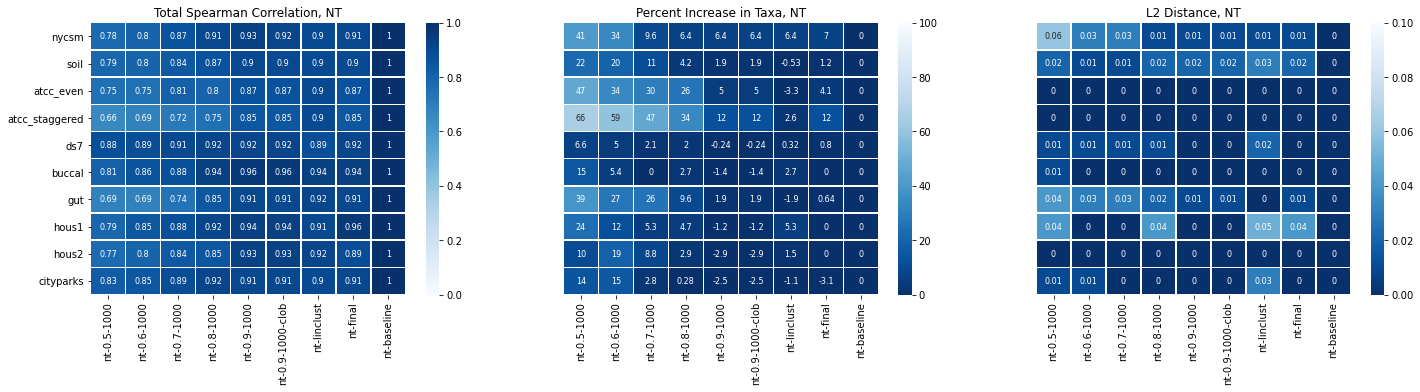

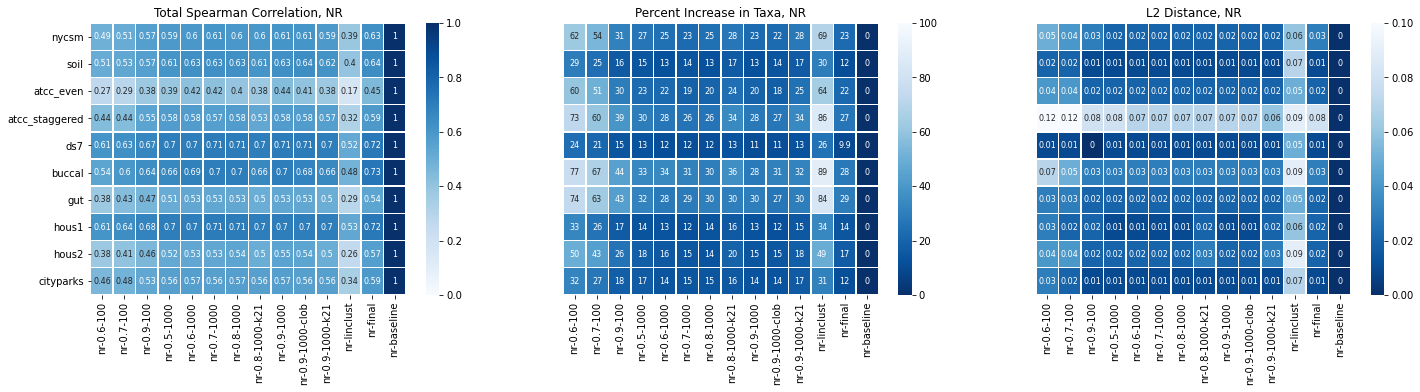

In [31]:
# FIGURE S3 DRAFT - Plot heatmaps for each metric, showing metrics across samples and parameters - FOR ALL PARAMETERS TESTED

column_order_nt = ['nt-0.5-1000', 'nt-0.6-1000', 'nt-0.7-1000', 'nt-0.8-1000', 'nt-0.9-1000', 'nt-0.9-1000-clob', 'nt-linclust', 'nt-final', 'nt-baseline'] #,'nt-refseq', 
column_order_nr = [ 'nr-0.6-100', 'nr-0.7-100', 'nr-0.9-100','nr-0.5-1000', 'nr-0.6-1000', 'nr-0.7-1000', 
                   'nr-0.8-1000', 'nr-0.8-1000-k21', 'nr-0.9-1000', 'nr-0.9-1000-clob', 'nr-0.9-1000-k21', 'nr-linclust', 'nr-final','nr-baseline'] #'nr-refseq', 

def plot_heatmap(input_df, plot_type, this_title):
    
    if plot_type == 'corr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues", as_cmap=True)
    elif plot_type == 'pct':
        this_vmax = 100
        this_vmin = 0 #-100
        cpal = sns.color_palette("Blues_r", as_cmap=True) #"RdBu_r"
    elif plot_type == 'l2':
        this_vmax = .1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    elif plot_type == 'aupr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    
    sns.heatmap(input_df, vmax = this_vmax, vmin = this_vmin, cmap=cpal, linewidths=.5, linecolor='white', annot=True, annot_kws={"size":8})#,figsize=(4,5))
    plt.title(this_title)
    #plt.show()

plt.figure(figsize=(24,5))

# plot nt correlation as heatmap
plt.subplot(1, 3, 1)
nt_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nt_corr_df = pd.DataFrame.from_dict(nt_corr_heatmap_data)
plot_heatmap(nt_corr_df[column_order_nt], plot_type='corr', this_title='Total Spearman Correlation, NT')

# plot nt pct_inc as heatmap
plt.subplot(1, 3, 2)
nt_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])        
nt_pctinc_df = pd.DataFrame.from_dict(nt_pctinc_heatmap_data)
plot_heatmap(np.round(nt_pctinc_df[column_order_nt],2), plot_type='pct', this_title='Percent Increase in Taxa, NT')
plt.yticks([])

# plot nt L2 as heatmap
plt.subplot(1, 3, 3)
nt_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
nt_l2_df = pd.DataFrame.from_dict(nt_l2_heatmap_data)
plot_heatmap(np.round(nt_l2_df[column_order_nt],2), plot_type='l2', this_title='L2 Distance, NT')
plt.yticks([])

plt.show()


plt.figure(figsize=(24,5))

# plot nr correlation as heatmap
plt.subplot(1, 3, 1)
nr_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nr_corr_df = pd.DataFrame.from_dict(nr_corr_heatmap_data)
nr_corr_df
plot_heatmap(nr_corr_df[column_order_nr], plot_type='corr', this_title='Total Spearman Correlation, NR')


# plot nr pct_inc as heatmap
plt.subplot(1, 3, 2)
nr_pctinc_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_pctinc_heatmap_data[i] = dict(aggregate_metrics_dict[i]['percent_increase'])
nr_pctinc_df = pd.DataFrame.from_dict(nr_pctinc_heatmap_data)
plot_heatmap(np.round(nr_pctinc_df[column_order_nr],2), plot_type='pct', this_title='Percent Increase in Taxa, NR')
plt.yticks([])

# plot nr L2 as heatmap
plt.subplot(1, 3, 3)
nr_l2_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_l2_heatmap_data[i] = dict(aggregate_metrics_dict[i]['l2_total'])
        
nr_l2_df = pd.DataFrame.from_dict(nr_l2_heatmap_data)
plot_heatmap(np.round(nr_l2_df[column_order_nr],2), plot_type='l2', this_title='L2 Distance, NR')
plt.yticks([])

plt.show()


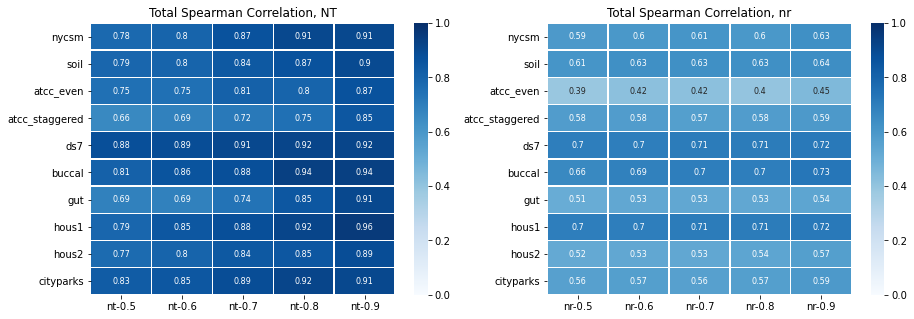

In [32]:
# FIGURE S3 - Plot heatmaps for each metric, showing metrics across samples and parameters

# this is final plot
column_order_nt = ['nt-0.5-1000', 'nt-0.6-1000', 'nt-0.7-1000', 'nt-0.8-1000', 'nt-final'] 
column_order_nt_names = ['nt-0.5', 'nt-0.6', 'nt-0.7', 'nt-0.8', 'nt-0.9']

column_order_nr = ['nr-0.5-1000', 'nr-0.6-1000', 'nr-0.7-1000', 'nr-0.8-1000', 'nr-final'] 
column_order_nr_names = ['nr-0.5', 'nr-0.6', 'nr-0.7', 'nr-0.8', 'nr-0.9']
nr_corr_df_renamed = nr_corr_df[column_order_nr]
nr_corr_df_renamed.columns = column_order_nr_names

def plot_heatmap(input_df, plot_type, this_title):
    
    if plot_type == 'corr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues", as_cmap=True)
    elif plot_type == 'pct':
        this_vmax = 100
        this_vmin = 0 #-100
        cpal = sns.color_palette("Blues_r", as_cmap=True) #"RdBu_r"
    elif plot_type == 'l2':
        this_vmax = .1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    elif plot_type == 'aupr':
        this_vmax = 1
        this_vmin = 0
        cpal = sns.color_palette("Blues_r", as_cmap=True)
    
    sns.heatmap(input_df, vmax = this_vmax, vmin = this_vmin, cmap=cpal, linewidths=.5, linecolor='white', annot=True, annot_kws={"size":8})#,figsize=(4,5))
    plt.title(this_title)

    
plt.figure(figsize=(15,5))

# plot nt correlation as heatmap
plt.subplot(1, 2, 1)
nt_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nt' in i:
        nt_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nt_corr_df = pd.DataFrame.from_dict(nt_corr_heatmap_data)
nt_corr_df_renamed = nt_corr_df[column_order_nt]
nt_corr_df_renamed.columns = column_order_nt_names
plot_heatmap(nt_corr_df_renamed, plot_type='corr', this_title='Total Spearman Correlation, NT')


# plot nr correlation as heatmap
plt.subplot(1, 2, 2)
nr_corr_heatmap_data = {}
for i in aggregate_metrics_dict.keys():
    if 'nr' in i:
        nr_corr_heatmap_data[i] = dict(aggregate_metrics_dict[i]['sc_total'])
nr_corr_df = pd.DataFrame.from_dict(nr_corr_heatmap_data)
nr_corr_df_renamed = nr_corr_df[column_order_nr]
nr_corr_df_renamed.columns = column_order_nr_names
plot_heatmap(nr_corr_df_renamed, plot_type='corr', this_title='Total Spearman Correlation, nr')

plt.savefig("./param_sweep_correlation_heatmap.pdf")
plt.show()


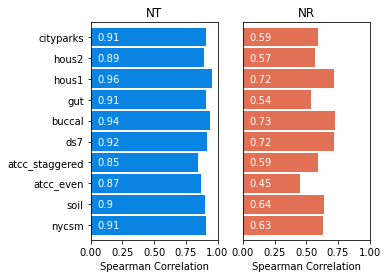

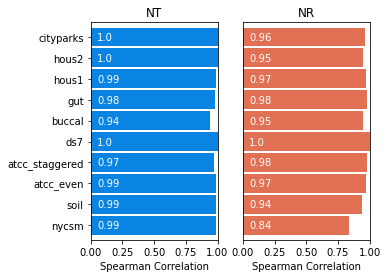

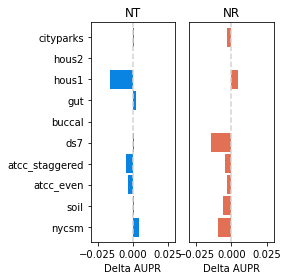

Delta L2


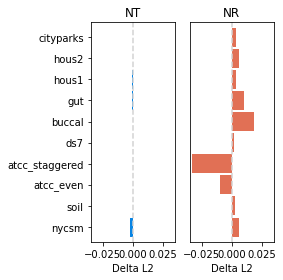

In [33]:
# FIGURE 2A, 2B, and 2C - For a specified parameterization, plot the key metrics to be shown alongside the main text

selected_nt = 'nt-final' # 'nt-linclust' #'nt-0.7-1000' # # 'nt-0.9-1000-clob'
selected_nr = 'nr-final' #'nr-linclust' #'nr-0.7-1000' #'nr-linclust' # 'nr-0.9-1000-clob'

this_data_nt = aggregate_metrics_dict[selected_nt]
#this_data_nt.drop(['norg_13'])
this_data_nr = aggregate_metrics_dict[selected_nr]
#this_data_nr.drop(['norg_13'])



plt.subplot(1, 2, 1)
this_data_nt['sc_total'].plot(kind='barh', width=.9, figsize=(5,4), xlim=(0,1), color=official_colors[5])
plt.xlabel('Spearman Correlation')
plt.title('NT')
for i, v in enumerate(this_data_nt['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
this_data_nr['sc_total'].plot(kind='barh', width=.9, figsize=(5,4), xlim=(0,1), color=official_colors[11])
plt.xlabel('Spearman Correlation')
plt.title('NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()


plt.subplot(1, 2, 1)
this_data_nt['sc_top'].plot(kind='barh', width=.9, figsize=(5,4), xlim=(0,1), color=official_colors[5])
plt.xlabel('Spearman Correlation')
plt.title('NT')
for i, v in enumerate(this_data_nt['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
this_data_nr['sc_top'].plot(kind='barh', width=.9, figsize=(5,4), xlim=(0,1), color=official_colors[11])
plt.xlabel('Spearman Correlation')
plt.title('NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.show()


plt.subplot(1, 2, 1)
#print(this_data_nt['delta_aupr'])
this_data_nt['delta_aupr'].plot(kind='barh', width=.9, figsize=(4,4), xlim=(-.03,.03), color=official_colors[5])
plt.xlabel('Delta AUPR')
plt.title('NT')
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')
#for i, v in enumerate(this_data_nt['delta_aupr']):
#    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.subplot(1, 2, 2)
#print(this_data_nr['delta_aupr'])
this_data_nr['delta_aupr'].plot(kind='barh', width=.9, figsize=(4,4), xlim=(-.03,.03), color=official_colors[11])
plt.xlabel('Delta AUPR')
plt.title('NR')
plt.yticks([])
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')
#for i, v in enumerate(this_data_nr['delta_aupr']):
#    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')
plt.tight_layout()
plt.savefig("./delta_aupr.pdf")
plt.show()

plt.subplot(1, 2, 1)
this_data_nt['delta_l2'].plot(kind='barh', width=.9, figsize=(4,4), xlim=(-.035,.035), color = official_colors[5])
plt.xlabel('Delta L2')
plt.title('NT')
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')

plt.subplot(1, 2, 2)
this_data_nr['delta_l2'].plot(kind='barh', width=.9, figsize=(4,4), xlim=(-.035,.035), color=official_colors[11])
plt.yticks([])
plt.xlabel('Delta L2')
plt.title('NR')
plt.axvline(x=0, linestyle='dashed', color = 'lightgrey')

print("Delta L2")
#print(this_data_nt['delta_l2'])
#print(this_data_nr['delta_l2'])
plt.tight_layout()
plt.savefig("./delta_l2.pdf")
plt.show()


#for i, v in enumerate(this_data_nr['l2_total']):
#    plt.text(0.01, i - .15, str(np.round(v,2)), color='black')


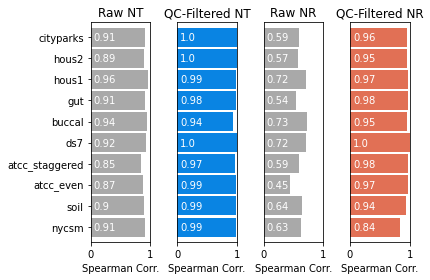

In [34]:

plt.subplot(1, 4, 1)
this_data_nt['sc_total'].plot(kind='barh', width=.9, figsize=(6,4), xlim=(0,1), color='darkgrey')
plt.xlabel('Spearman Corr.')
plt.title('Raw NT')
for i, v in enumerate(this_data_nt['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

    
plt.subplot(1, 4, 2)
this_data_nt['sc_top'].plot(kind='barh', width=.9, figsize=(6,4), xlim=(0,1), color=official_colors[5])
plt.xlabel('Spearman Corr.')
plt.title('QC-Filtered NT')
plt.yticks([])
for i, v in enumerate(this_data_nt['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

    
plt.subplot(1, 4, 3)
this_data_nr['sc_total'].plot(kind='barh', width=.9, figsize=(6,4), xlim=(0,1), color='darkgrey')
plt.xlabel('Spearman Corr.')
plt.title('Raw NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_total']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')


plt.subplot(1, 4, 4)
this_data_nr['sc_top'].plot(kind='barh', width=.9, figsize=(6,4), xlim=(0,1), color=official_colors[11])
plt.xlabel('Spearman Corr.')
plt.title('QC-Filtered NR')
plt.yticks([])
for i, v in enumerate(this_data_nr['sc_top']):
    plt.text(0.05, i - .15, str(np.round(v,2)), color='white')

plt.tight_layout()
plt.savefig("./raw_vs_filtered_correlation.pdf")

plt.show()


In [35]:
# Specific analysis comparing the AUPR for gold standard samples with original vs. refseq vs. select compressed version
list_of_values = [aggregate_metrics_dict['nt-baseline']['aupr_gs_new'],
                  aggregate_metrics_dict['nt-linclust']['aupr_gs_new'],
                  aggregate_metrics_dict['nt-final']['aupr_gs_new'],
                  aggregate_metrics_dict['nr-baseline']['aupr_gs_new'],
                  aggregate_metrics_dict['nr-linclust']['aupr_gs_new'],
                 aggregate_metrics_dict['nr-final']['aupr_gs_new']]
results_compared_to_refseq = pd.concat(list_of_values, axis=1)
results_compared_to_refseq.columns = ['nt-baseline', 'nr-baseline', 'nt-linclust', 'nr-linclust', 'nt-final', 'nr-final'] #'nt-refseq',  'nr-refseq', 
results_compared_to_refseq

,nt-baseline,nr-baseline,nt-linclust,nr-linclust,nt-final,nr-final
nycsm,0.853318,0.852893,0.857570,0.924168,0.879163,0.914388
soil,0.943072,0.899324,0.943682,0.979393,0.865063,0.973215
atcc_even,0.019102,0.011976,0.015936,0.019102,0.011976,0.015936
atcc_staggered,0.022026,0.012210,0.017422,0.022026,0.012210,0.017422
ds7,0.938052,0.902930,0.938889,0.891512,0.817706,0.877149
buccal,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
gut,0.988716,0.988716,0.990978,1.000000,0.988061,1.000000
hous1,0.906162,0.893112,0.890021,0.961398,0.856850,0.966344
hous2,0.946211,0.945895,0.946070,1.000000,0.939049,1.000000
cityparks,0.972294,0.888743,0.972912,0.979857,0.856035,0.976877


In [36]:
# TODO - figure out how to make this printf work! 
# TODO - text says "regardless of sequencing technology" which would require making this whole script compatible with the zymobiomics sample

print("Average Delta AUPR NT: %f, SD = %f" % (np.round(np.mean(this_data_nt['delta_aupr']),3), np.round(np.std(this_data_nt['delta_aupr']), 3)))
print("Average Delta AUPR NR: %f, SD = %f" % (np.round(np.mean(this_data_nr['delta_aupr']),3), np.round(np.std(this_data_nr['delta_aupr']), 3)))


print("Average Delta L2 NT: %f, SD = %f" % (np.round(np.mean(this_data_nt['delta_l2']),3), np.round(np.std(this_data_nt['delta_l2']), 3)))
print("Average Delta L2 NR: %f, SD = %f" % (np.round(np.mean(this_data_nr['delta_l2']),3), np.round(np.std(this_data_nr['delta_l2']), 3)))



print("NT Delta AUPR range: %f - %f" % (np.min(this_data_nt['delta_aupr']), np.max(this_data_nt['delta_aupr'])))
print("NT Delta L2 range: %f - %f" % (np.min(this_data_nt['delta_l2']), np.max(this_data_nt['delta_l2'])))

print("NR Delta AUPR range: %f - %f" % (np.min(this_data_nr['delta_aupr']), np.max(this_data_nr['delta_aupr'])))
print("NR Delta L2 range: %f - %f" % (np.min(this_data_nr['delta_l2']), np.max(this_data_nr['delta_l2'])))



print("(NT) average spearman correlation %f (SD = %f)" % (np.mean(this_data_nt['sc_total']), np.std(this_data_nt['sc_total'])))
print("(NR) average spearman correlation %f (SD = %f)" % (np.mean(this_data_nr['sc_total']), np.std(this_data_nr['sc_total'])))

print("(NT) average QC-filtered spearman correlation %f (SD = %f)" % (np.mean(this_data_nt['sc_top']), np.std(this_data_nt['sc_top'])))
print("(NR) average QC-filtered spearman correlation %f (SD = %f)" % (np.mean(this_data_nr['sc_top']), np.std(this_data_nr['sc_top'])))


print("(NT) average L2 distance = %f (SD = %f)" % (np.mean(this_data_nt['l2_total']), np.std(this_data_nt['l2_total'])))
print("(NR) average L2 distance = %f (SD = %f)" % (np.mean(this_data_nr['l2_total']), np.std(this_data_nt['l2_total'])))
print("L2 distances remained low ( < %f for NT, %f for NR)" % (np.max(this_data_nt['l2_total']), np.max(this_data_nr['l2_total'])))


Average Delta AUPR NT: -0.002000, SD = 0.005000
Average Delta AUPR NR: -0.004000, SD = 0.005000
Average Delta L2 NT: -0.000000, SD = 0.001000
Average Delta L2 NR: 0.001000, SD = 0.013000
NT Delta AUPR range: -0.016142 - 0.004253
NT Delta L2 range: -0.002451 - 0.000069
NR Delta AUPR range: -0.014363 - 0.004946
NR Delta L2 range: -0.032743 - 0.018718
(NT) average spearman correlation 0.906000 (SD = 0.030067)
(NR) average spearman correlation 0.618000 (SD = 0.084947)
(NT) average QC-filtered spearman correlation 0.985000 (SD = 0.017464)
(NR) average QC-filtered spearman correlation 0.954000 (SD = 0.041521)
(NT) average L2 distance = 0.008369 (SD = 0.012864)
(NR) average L2 distance = 0.024401 (SD = 0.012864)
L2 distances remained low ( < 0.043605 for NT, 0.082932 for NR)


### Accuracy metrics for Medical Detectives

This section extends the above metrics for analysis of real-world datsets (Medical Detectives)

In [37]:
# INPUT FILES

# This manifest is intended to specify the input OLD v. NEW samples

manifest = {
            'sample-A': {'goldstandard': 'XXXX', 'old': "sample-A_report.csv", 'new': "sample-A_report.csv", "known_sp": "Aspergillus flavus"},
            'sample-B': {'goldstandard': 'XXXX', 'old': "sample-B_report.csv", 'new': "sample-B_report.csv", "known_sp": "Cryptococcus neoformans"},
            'sample-C': {'goldstandard': 'XXXX', 'old': "sample-C_report.csv", 'new': "sample-C_report.csv", "known_sp": "Taenia solium"},
            'sample-D': {'goldstandard': 'XXXX', 'old': "sample-D_report.csv", 'new': "sample-D_report.csv", "known_sp": "Chikungunya virus"},
            'sample-E': {'goldstandard': 'XXXX', 'old': "sample-E_report.csv", 'new': "sample-E_report.csv", "known_sp": "Chikungunya virus"},
            'sample-F': {'goldstandard': 'XXXX', 'old': "sample-F_report.csv", 'new': "sample-F_report.csv", "known_sp": "Neisseria meningitidis"},
            'sample-G': {'goldstandard': 'XXXX', 'old': "sample-G_report.csv", 'new': "sample-G_report.csv", "known_sp": "Elizabethkingia anophelis"},
            'sample-H': {'goldstandard': 'XXXX', 'old': "sample-H_report.csv", 'new': "sample-H_report.csv", "known_sp": "Rubella virus"},
            'sample-I': {'goldstandard': 'XXXX', 'old': "sample-I_report.csv", 'new': "sample-I_report.csv", "known_sp": "Balamuthia mandrillaris"}
        }


# This specifies which parameters were used in each set of pipeline runs
metadata_manifest = {
    #'2023_01_22_clobbered_compressed_nt_and_nr_k_31_thresh_0-9_scaled_1000':{ 'nt': 'nt-0.9-1000', 'nr': 'nr-0.9-1000'}
    '2021_compressed_new_approach':{ 'nt': 'nt-final', 'nr': 'nr-final'}
}

# Run through each directory in the metadata manifest (each experiment) and calculate the metrics, formatting based on the relevant parameters

aggregate_metrics_dict = {}

for this_iteration in metadata_manifest.keys():
    
    for db in metadata_manifest[this_iteration].keys(): 
        
        print(this_iteration)
        print(db)
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = {}
        
        current_db = db

        prefix_old = "./data/BASELINE_MD/"
        prefix_new = "./data/NEW_MD/" + this_iteration + "/"
        prefix_gs = "./data/GOLD_STANDARD/"

        final_metrics_dict = {}
        for i in manifest.keys():

            old_taxon_counts = prefix_old + manifest[i]["old"]
            new_taxon_counts = prefix_new + manifest[i]["new"]
            gold_standard = prefix_gs + manifest[i]["goldstandard"]
            known_sp = manifest[i]["known_sp"]

            final_metrics_dict[i] = generate_metrics(old_taxon_counts, new_taxon_counts, gold_standard, known_sp, current_db, show_plots = False)

        final_metrics_df = pd.DataFrame.from_dict(final_metrics_dict, orient='index')
        final_metrics_df
        
        aggregate_metrics_dict[metadata_manifest[this_iteration][db]] = final_metrics_df


2021_compressed_new_approach
nt
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Aspergillus flavus
0.3915250927553212
0.39099063962558506
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Cryptococcus neoformans
0.9043854539402513
0.906490694866564
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Taenia solium
0.7740682985579018
0.7753485111316837
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Chikungunya virus
0.6590010057431492
0.6590747898627912


/Users/katrina.kalantar/opt/anaconda3/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Chikungunya virus
0.23465121834687055
0.23529552667824422
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Neisseria meningitidis
0.8631195909500431
0.8676874057925518
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Elizabethkingia anophelis
0.7149454419533328
0.7151440625142752
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Rubella virus
0.060364842454394683
0.06132665832290362
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Balamuthia mandrillaris
0.09414332632953222
0.09414955443626502
2021_compressed_new_approach
nr
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Aspergillus flavus
0.12324649298597198
0.10784641068447413
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Cryptococcus neoformans
0.05064522953247303
0.051269572577232345
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Taenia solium
0.3116018288948742
0.31172476125917203
NO GOLD STANDARD FOR: ./data/GOLD_STANDARD/XXXX
Chikungunya virus
0.6428443731053224
0.6428662385153534
N

In [38]:
selected_nt = 'nt-final' # 'nt-0.9-1000'
selected_nr = 'nr-final' #'nr-0.9-1000'

this_data_nt = aggregate_metrics_dict[selected_nt]
#print(this_data_nt)
#this_data_nt.drop(['norg_13'])
this_data_nr = aggregate_metrics_dict[selected_nr]
#this_data_nr.drop(['norg_13'])


this_data_nt['delta_prop']

sample-A   -0.000534
sample-B    0.002105
sample-C    0.001280
sample-D    0.000074
sample-E    0.000644
sample-F    0.004568
sample-G    0.000199
sample-H    0.000962
sample-I    0.000006
Name: delta_prop, dtype: float64

In [39]:
np.round(this_data_nt[['known_sp_prop_old', 'known_sp_prop_new', 'delta_prop']], 3)

,known_sp_prop_old,known_sp_prop_new,delta_prop
sample-A,0.392,0.391,-0.001
sample-B,0.904,0.906,0.002
sample-C,0.774,0.775,0.001
sample-D,0.659,0.659,0.000
sample-E,0.235,0.235,0.001
sample-F,0.863,0.868,0.005
sample-G,0.715,0.715,0.000
sample-H,0.060,0.061,0.001
sample-I,0.094,0.094,0.000


In [40]:
np.round(this_data_nr[['known_sp_prop_old', 'known_sp_prop_new', 'delta_prop']],3)

,known_sp_prop_old,known_sp_prop_new,delta_prop
sample-A,0.123,0.108,-0.015
sample-B,0.051,0.051,0.001
sample-C,0.312,0.312,0.000
sample-D,0.643,0.643,0.000
sample-E,0.230,0.230,-0.000
sample-F,0.778,0.697,-0.081
sample-G,0.022,0.021,-0.002
sample-H,0.034,0.034,0.000
sample-I,0.000,0.000,0.000


In [41]:
print("(NT) average delta prop %f (SD = %f)" % (np.mean(this_data_nt['delta_prop']), np.std(this_data_nt['delta_prop'])))
print("(NR) average delta prop %f (SD = %f)" % (np.mean(this_data_nr['delta_prop']), np.std(this_data_nr['delta_prop'])))


print("(NT) average spearman correlation %f (SD = %f)" % (np.mean(this_data_nt['sc_total']), np.std(this_data_nt['sc_total'])))
print("(NR) average spearman correlation %f (SD = %f)" % (np.mean(this_data_nr['sc_total']), np.std(this_data_nr['sc_total'])))

print("(NT) average QC-filtered spearman correlation %f (SD = %f)" % (np.mean(this_data_nt['sc_top']), np.std(this_data_nt['sc_top'])))
print("(NR) average QC-filtered spearman correlation %f (SD = %f)" % (np.mean(this_data_nr['sc_top']), np.std(this_data_nr['sc_top'])))


print("(NT) average L2 Dist %f (SD = %f)" % (np.mean(this_data_nt['l2_total']), np.std(this_data_nt['l2_total'])))
print("(NR) average L2 Dist %f (SD = %f)" % (np.mean(this_data_nr['l2_total']), np.std(this_data_nr['l2_total'])))


print("L2 distances remained low ( < %f for NT, %f for NR)" % (np.max(this_data_nt['l2_total']), np.max(this_data_nr['l2_total'])))


(NT) average delta prop 0.001034 (SD = 0.001453)
(NR) average delta prop -0.010808 (SD = 0.025150)
(NT) average spearman correlation 0.691111 (SD = 0.109590)
(NR) average spearman correlation 0.802222 (SD = 0.036751)
(NT) average QC-filtered spearman correlation 0.978889 (SD = 0.032470)
(NR) average QC-filtered spearman correlation 0.992222 (SD = 0.010304)
(NT) average L2 Dist 0.058375 (SD = 0.068163)
(NR) average L2 Dist 0.041856 (SD = 0.054711)
L2 distances remained low ( < 0.187038 for NT, 0.180104 for NR)
